# Floating Point Streaming Service Recommendation System
## A tool for recommending songs based on current song selection

In [4]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

from IPython.display import clear_output
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

%matplotlib inline

In [5]:
# Upload data
songs = pd.read_csv('./spotify_songs.csv')

In [6]:
# Clean our data of null and duplicate values, and drop any fields we won't be making use of
songs.dropna(inplace=True)
songs.drop_duplicates(inplace=True)
songs = songs.drop(['track_popularity', 'track_album_id', 'track_album_release_date', 'playlist_name', 'playlist_id', 'mode'], axis = 1)
df_songs = pd.DataFrame(songs)

In [7]:
#Take just the columns needed for analysis
features = list(songs.columns[6:])
song_features = songs[features]
df_song_features = pd.DataFrame(song_features)

   This tool will use unsupervised k-means clustering in order to recommend ten songs that are similar to the song that is currently selected. In order to make sure that our data is clean and processed for use in data analysis, we look at different characteristics of our songs and try to find any correlation between these characteristics. The goal of this is to find any redundant factors and simplify them. In order to achieve this goal, a heatmap has been developed to show these correlations:

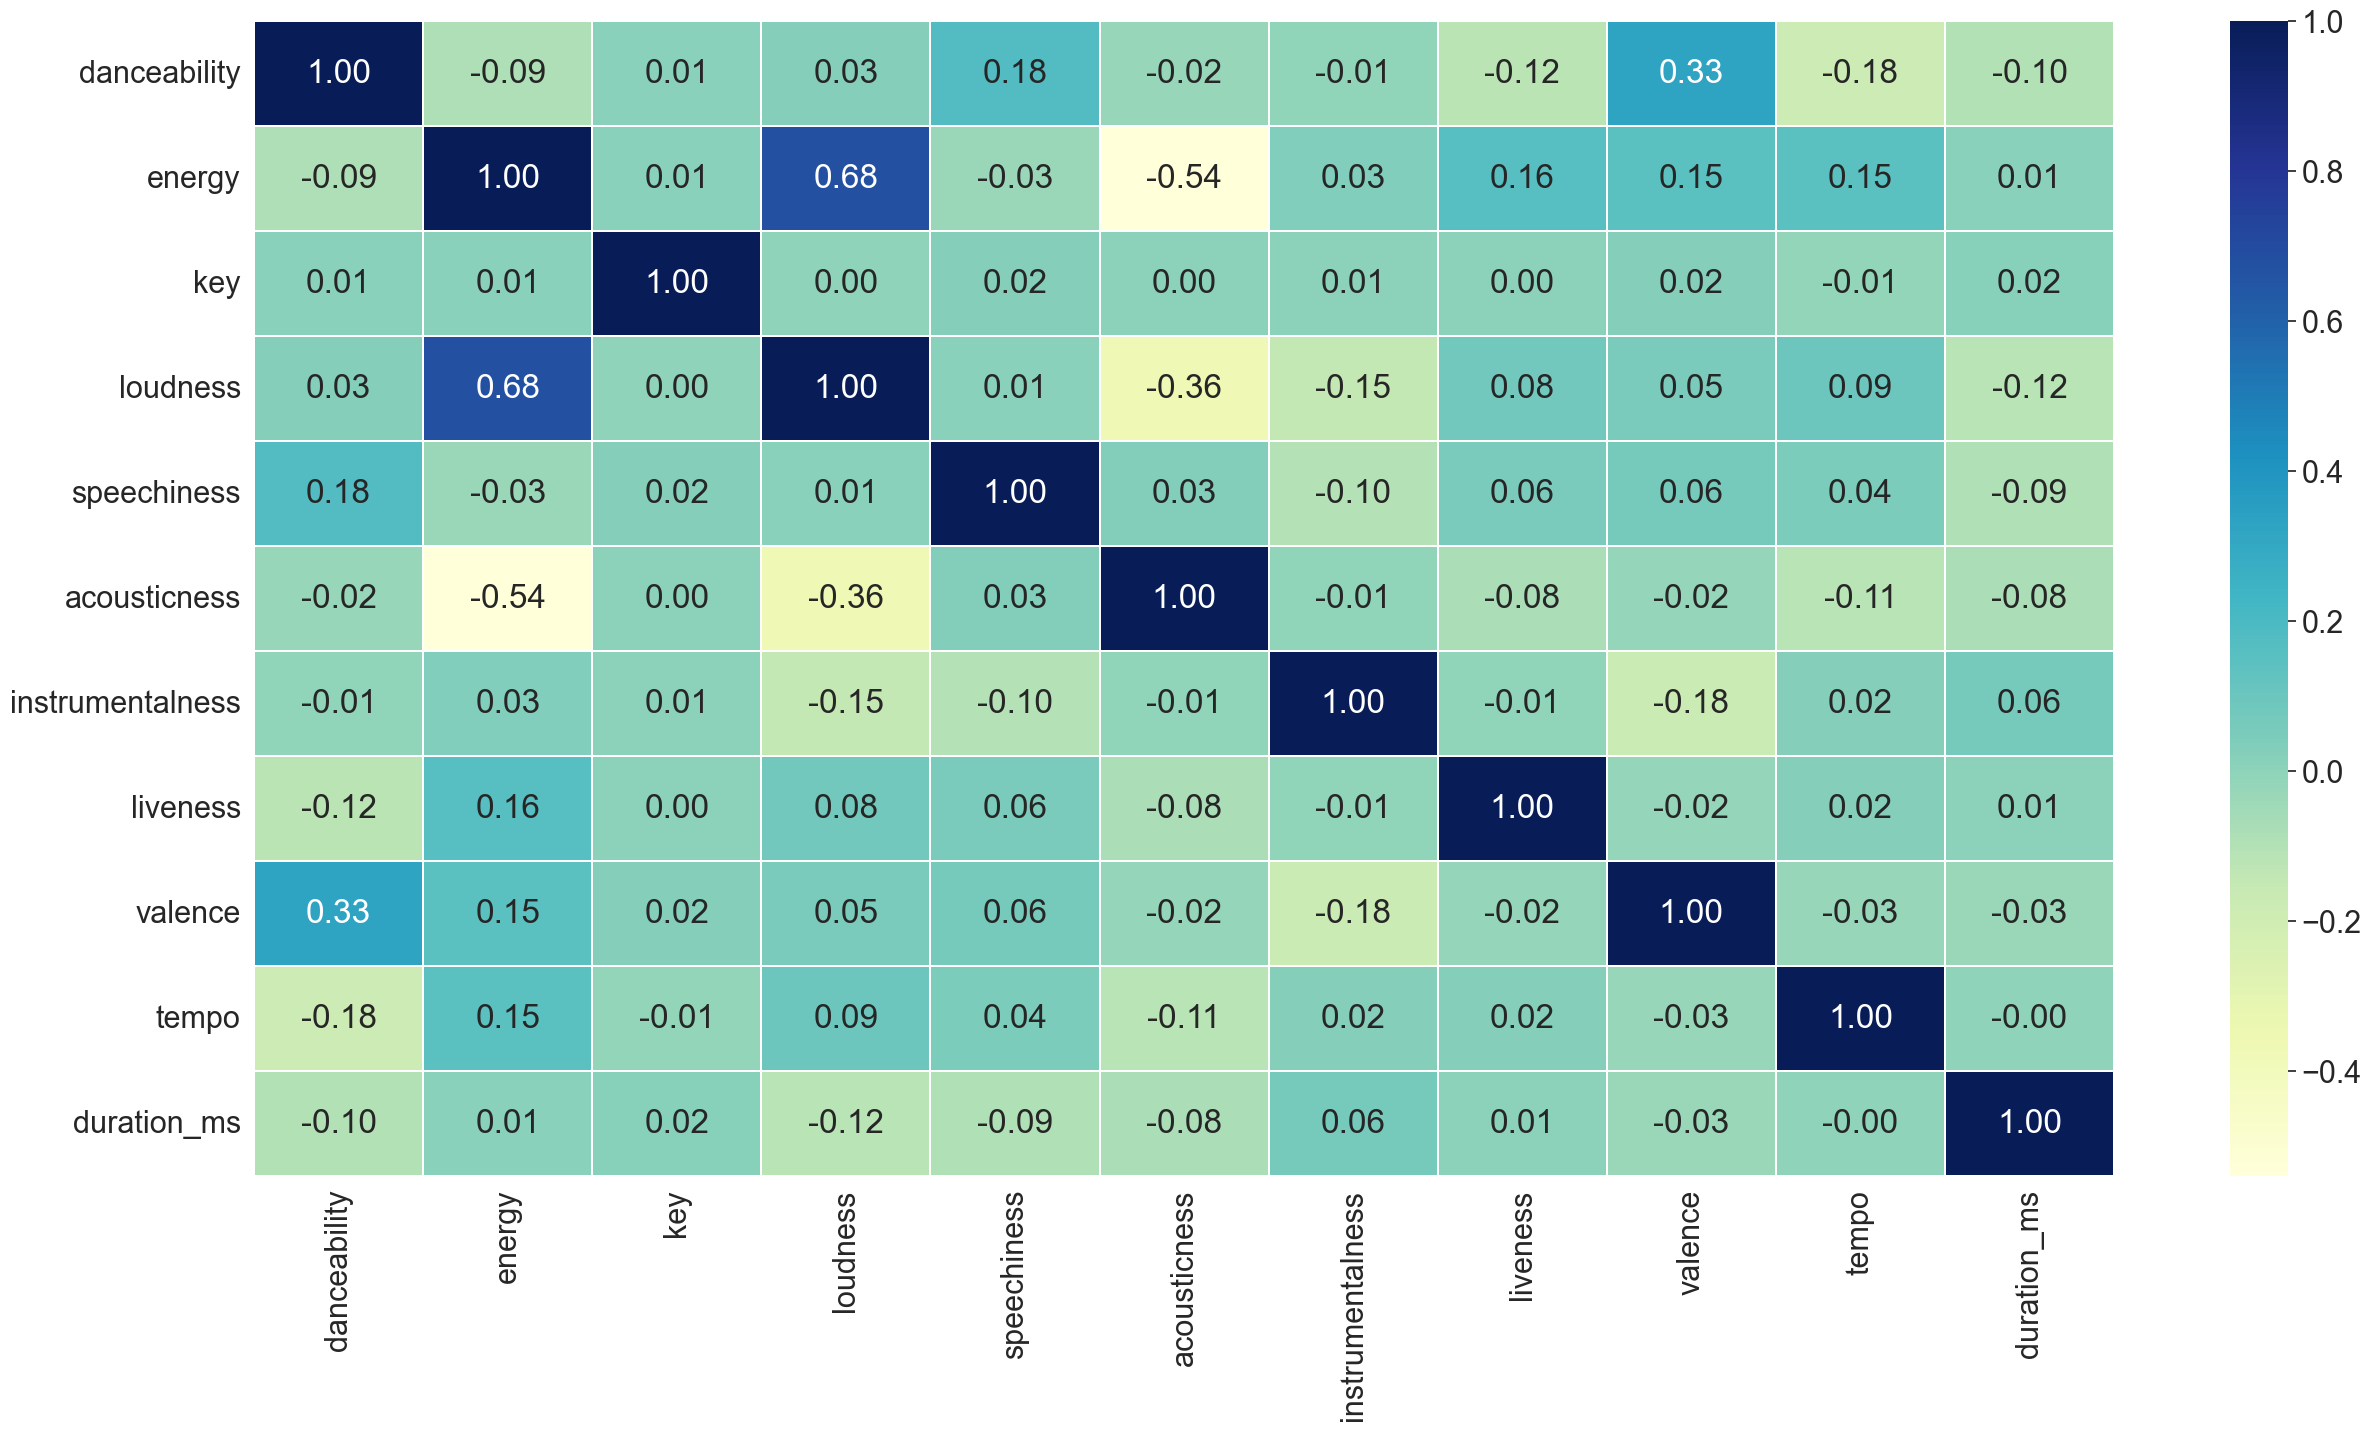

In [8]:
#Create a heatmap of correlation between factors to see if any further processing is needed
#Valence and danceability show a weak correlation, but loudness and energy have a strong correlation
#Since energy and loudness share a correlation coefficient lower than 0.7, I will not process them any further
plt.figure(figsize = (30, 15))
sns.set(font_scale = 2)
heatmap = sns.heatmap(song_features.corr(), annot = True, fmt='.2f', cmap = 'YlGnBu', linewidths = 0.2, xticklabels=True, yticklabels=True)

   As the heatmap shows, loudness and energy share a fairly strong positive correlation coefficient of 0.68, and valence and danceability share a weak positive correlation coefficient of 0.33. Also, acousticness and energy share a fairly strong negative correlation coefficient of -0.54, while acousticness and loudness share a weak negative correlation coefficient of -0.36. Because the strongest correlation has a coefficient between 0.7 and -0.7, no more preprocessing should be necessary at this point.

In [9]:
#Scale the data for k-means clustering
scaler = MinMaxScaler()
scaled_songs = scaler.fit_transform(song_features)
df_scaled_songs = pd.DataFrame(scaled_songs)

   Now we need to find the optimal amount of clusters to be used in our k-mean clustering algorithm. In order to do this, we plot a line graph of the sum of squared distances between nodes in clusters. Using this graph, we find the largest drop in distance, which will appear as a kink or an elbow on the graph. We will also be measuring the accuracy of each model using silhouette score in order to determine cluster similarity.

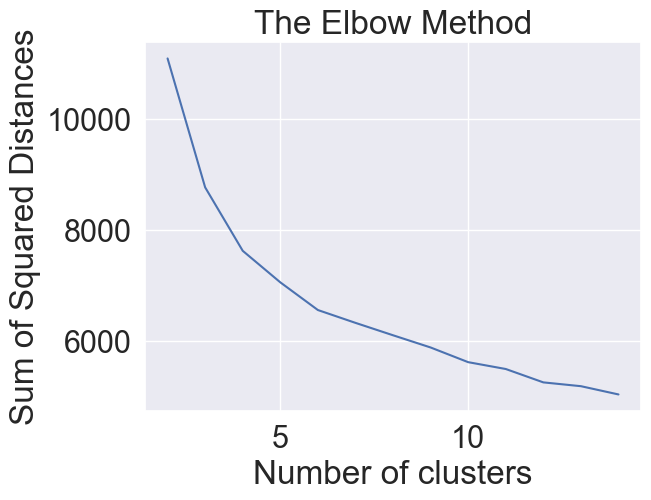

In [10]:
#Deploy the Elbow Method in order to determine the proper amount of clusters
#Elbows are indentified at 3, 5, and 6 clusters, and the best silhouette score is achieved at 3 clusters
cs = []
for i in range(2, 15):
    kmeans = KMeans(n_clusters = i, init = 'k-means++')
    kmeans.fit(scaled_songs)
    cs.append(kmeans.inertia_)
plt.plot(range(2, 15), cs)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Squared Distances')
plt.show()

   This analysis shows that the largest elbow is at 3 clusters, while the highest silhouette score is achieved at 3 clusters, so for our k-means clustering we will be using 3 clusters. After training the model, we run the processed data through Primary Component Analysis in order to cut down on variables for visualization's sake. We then check the explained variance ratios of our principal components to see how accurately each component is represented in the data.

In [11]:
#Set clusters to 3 and test our k-means clustering model
kmeans = KMeans(n_clusters=3)
kmeans.fit(scaled_songs)
prediction = kmeans.predict(scaled_songs)
s = silhouette_score(scaled_songs, prediction, metric = 'euclidean')
print('Silhouette Score at 3 clusters:', s)
df_scaled_songs['cluster'] = kmeans.labels_

df_joined = pd.concat([df_songs,df_scaled_songs], axis=1)
df_joined = df_joined.drop(['track_id', 'track_album_name', 'playlist_genre', 'playlist_subgenre', 'danceability', 'energy', 'key', 'loudness', 'speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_ms',0,1,2,3,4,5,6,7,8,9,10], axis=1)
df_joined.dropna(inplace=True)

Silhouette Score at 3 clusters: 0.21173637666644418


In [12]:
#Apply PCA in order to reduce dimensions
pca = PCA(n_components=5)
pca_songs = pca.fit_transform(scaled_songs)
minor_cluster = df_scaled_songs['cluster'].value_counts().tail(1)
sampled_clusters_pca = pd.DataFrame()

pca_df = pd.DataFrame(pca_songs)
pca_df.columns = [f'PC{i}' for i in range(5)]
pca_df['cluster'] = kmeans.labels_

In [13]:
explained_variance = pca.explained_variance_ratio_
total = explained_variance.sum()
print(f"EVR: {explained_variance}")
print(f"Sum: {total:.4f}")

EVR: [0.28115056 0.17877753 0.1646447  0.11799827 0.06755174]
Sum: 0.8101


   Using our desired dimensionality and primary components, we can build a scatterplot of the data showing each song's similarity in relation to one another.

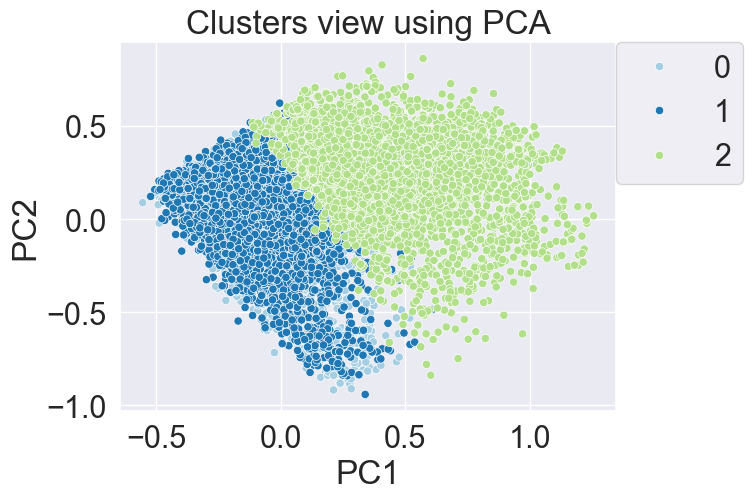

In [14]:
#Form a scatterplot using Primary Component Analysis of the clusters
for c in range(0,3):
    df_cluster_sampled_pca = pca_df[pca_df.cluster == (c)].sample(n=(minor_cluster.values), random_state=42)
    sampled_clusters_pca = pd.concat([sampled_clusters_pca,df_cluster_sampled_pca], axis=0)
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=sampled_clusters_pca, legend="full", palette='Paired')
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
plt.title('Clusters view using PCA')
plt.show()

In [15]:
#Define recommendation formula to give our users 10 songs in the same cluster
def clear():
    os.system('cls')

def recommend(track_id):
    cluster = df_joined.loc[track_id, 'cluster']
    recommendations = df_joined[df_joined['cluster'] == cluster].sample(n=10)
    recommendations = recommendations.drop(['cluster'], axis=1)
    return recommendations

   Now that the data has been processed using k-means clustering and analyzed for accuracy, the recommendation tool is ready for use. In order to use this tool, enter the number ID of any song in the library of 32000 songs into the input field below, and then click the Recommend button. A list of 10 songs in the same group as the song you selected will appear.

In [16]:
#Create user interface in order to demonstrate recommendation functionality
id_widget = widgets.FloatText(description='Song ID', value='0')
button_recommend = widgets.Button(description='Recommend')
button_output = widgets.Output()
def button_click(b):
    if (-1 < id_widget.value < 32001):
        recommendation = recommend(id_widget.value)
        with button_output:
            clear_output(wait=True)
            print(recommendation)
    else:
        with button_output:
            clear_output(wait=True)
            print('Track not found')
button_recommend.on_click(button_click)
vb=widgets.VBox([id_widget, button_recommend, button_output])
display(vb)

Thank you for using this tool, and have a great day!